In [81]:
import tqdm as notebook_tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.init as init

from sklearn.metrics import r2_score

#import torch.nn.functional as F
#
#import torch.nn.init as init

#%matplotlib inline
#import matplotlib

#from torch.nn.parameter import Parameter

In [101]:
# Data Parameters
minx = 0
maxx = 10
n_samples_volume = 500
n_samples_boundary = 500
n_samples = n_samples_volume + n_samples_boundary

In [102]:
# Right hand side function f(x) of the PDE
def Function_f(x = 0, y = 0, z = 0):
    
    # Returning for the Poisson Equation in one dimension, u''(x) = f(x) 
    return Function_u_xx(x,y,z)

In [103]:
# Hidden function u(x)
def Function_u(x = 0, y = 0, z = 0):
    #return 1/np.sqrt(x**2 + y**2 + z**2)
    return x**3 + 2*x + 5

# Diff of hidden function u'(x)
def Function_u_x(x = 0, y = 0, z = 0):
    return 3*x**2 + 2

# Double diff of hidden function u''(x)
def Function_u_xx(x = 0, y = 0, z = 0):
    return 6*x

In [104]:
# Sampling from the function
def Sample(x = 0, y = 0, z = 0):
    return Function_u_xx(x,y,z)

In [ ]:
def Sample_boundary(x = 0, y = 0, z = 0):
    if ( abs(np.sqrt(x**2 + y**2 + z**2) - minx) <= 0.001):
        # On the boundary
        return Function_u_x(x,y,z)

In [105]:
x = np.arange(minx, maxx, (maxx-minx)/n_samples_volume)

x = np.append(x, np.full(int(n_samples_boundary/2), minx))
x = np.append(x, np.full(int(n_samples_boundary/2), maxx))

y = np.zeros(len(x))
y_bound = np.zeros(len(x))
u = np.zeros(len(x))
u_x = np.zeros(len(x))
u_xx = np.zeros(len(x))

for i in range(len(x)):
    # x On the boundary
    if ( abs(np.sqrt(x**2 + y**2 + z**2) - minx) <= 0.001):
        y_bound[i] = Sample_boundary(x[i])
    y[i] = Sample(x[i])
    u[i] = Function_u(x[i])
    u_x[i] = Function_u_x(x[i])
    u_xx[i] = Function_u_xx(x[i])

data = np.empty([n_samples, 3])
data[:,0] = x
data[:,1] = y
data[:,2] = y_bound

np.random.shuffle(data)

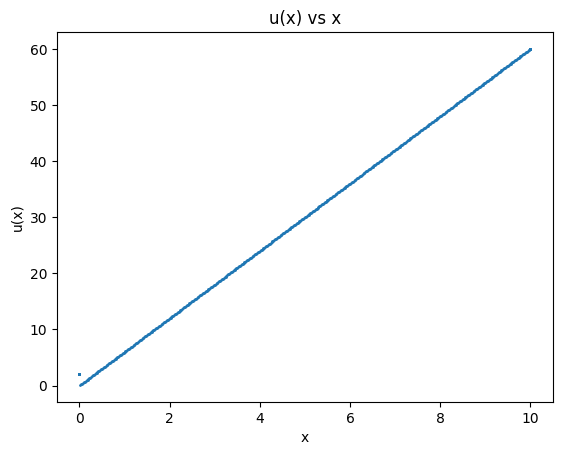

In [106]:
# Plotting reference function
plt.figure()
plt.scatter(data[:,0], data[:,1], s = 1)
plt.title("u(x) vs x")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.show()

In [74]:
# Splitting data into training, testing and validation
percentage_train = 0.8
percentage_test = 0.2
percentage_validation = 1 - percentage_train - percentage_test

N_train = int(np.floor(percentage_train*np.size(data[:,0])))
N_test = int(np.floor(percentage_test*np.size(data[:,0])))
N_validation = int(np.floor(percentage_validation*np.size(data[:,0])))
print("Number of training data sets:", N_train)
print("Number of test data sets:", N_test)
print("Number of validation data sets:", N_validation)

train = data[:N_train,:]
train_x = data[:N_train - 1, 0]
train_y = data[:N_train - 1, 1]

test = data[N_train: N_train + N_test - 1,:]
test_x = data[N_train: N_train + N_test - 1, 0]
test_y = data[N_train: N_train + N_test - 1, 1]

validation = data[N_train + N_test: , :]
validation_x = data[N_train + N_test: , 0]
vaildation_y = data[N_train + N_test: , 1]

print("Dimensions of data sets:", np.shape(data))
print("Dimensions of training data sets:", np.shape(train))
print("Dimensions of test data sets:", np.shape(test))
print("Dimensions of validation data sets:", np.shape(validation))

Number of training data sets: 800
Number of test data sets: 200
Number of validation data sets: -1
Dimensions of data sets: (1000, 2)
Dimensions of training data sets: (800, 2)
Dimensions of test data sets: (199, 2)
Dimensions of validation data sets: (0, 2)


In [75]:
#Change numpy array to tensor
train_x = torch.from_numpy(train[:,0]).unsqueeze(1).float()
train_y = torch.from_numpy(train[:,1]).unsqueeze(1).float()
test_x = torch.from_numpy(test[:,0]).unsqueeze(1).float()
test_y = torch.from_numpy(test[:,1]).unsqueeze(1).float()

In [76]:
# define network architecture
input_dim = 1
output_dim = 1
num_hidden = 300

class Net(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, output_dim),
        )

    def forward(self, x):
        y_out = self.linear_relu_stack(x)
        return y_out
    
net = Net(num_hidden)
    
# hyperparameters
learning_rate = 1e-5
batch_size = 50
num_epochs = 1000

#loss
loss_fn = nn.MSELoss()

#optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Epoch  1 : Train Loss 1854.427002 , Train r2 -1.268857, Test r2 -1.564162
Epoch 51 : Train Loss 1020.363464 , Train r2 -0.244795, Test r2 -0.388823
Epoch 101 : Train Loss 354.709808 , Train r2 0.570201, Test r2 0.534560
Epoch 151 : Train Loss 70.478409 , Train r2 0.914784, Test r2 0.908767
Epoch 201 : Train Loss 31.372686 , Train r2 0.961492, Test r2 0.949741
Epoch 251 : Train Loss 28.915136 , Train r2 0.964460, Test r2 0.951076
Epoch 301 : Train Loss 26.829632 , Train r2 0.967030, Test r2 0.954231
Epoch 351 : Train Loss 24.377493 , Train r2 0.970052, Test r2 0.958069
Epoch 401 : Train Loss 21.624012 , Train r2 0.973443, Test r2 0.962377
Epoch 451 : Train Loss 18.630337 , Train r2 0.977128, Test r2 0.967099
Epoch 501 : Train Loss 15.707867 , Train r2 0.980721, Test r2 0.971761
Epoch 551 : Train Loss 13.136635 , Train r2 0.983878, Test r2 0.975894
Epoch 601 : Train Loss 11.041203 , Train r2 0.986450, Test r2 0.979307
Epoch 651 : Train Loss 9.425246 , Train r2 0.988432, Test r2 0.982007


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

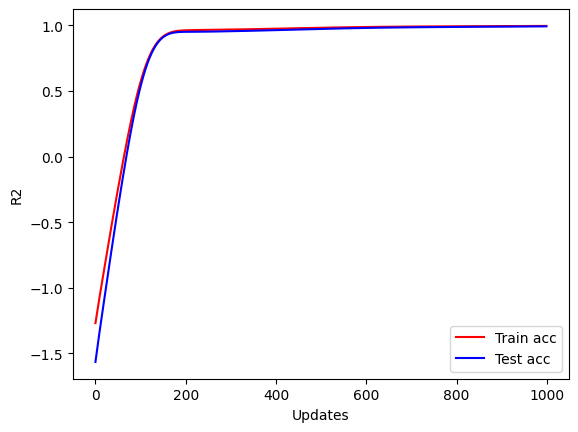

In [77]:
# train network

#getting epoch sizes
num_samples_train = train_x.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_test = test_x.shape[0]
num_batches_test = num_samples_test // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size) #get slices for each batch

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(train_x[slce])

        # compute gradients given loss
        y_batch = train_y[slce]
        batch_loss = loss_fn(output, y_batch)
        batch_loss.backward()
        optimizer.step()

        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(train_x[slce])

        preds = output.squeeze(1)

        train_targs += list(train_y[slce].numpy())
        train_preds += list(preds.data.numpy())

    ### Evaluate test
    test_preds, test_targs = [], []
    for i in range(num_batches_test):
        slce = get_slice(i, batch_size)

        output = net(test_x[slce])
        preds = output.squeeze(1)
        test_targs += list(test_y[slce].numpy())
        test_preds += list(preds.data.numpy())


    train_r2 = r2_score(train_targs, train_preds)
    test_r2 = r2_score(test_targs, test_preds)

    train_acc.append(train_r2)
    test_acc.append(test_r2)

    if epoch % 50 == 0:
        print("Epoch %2i : Train Loss %f , Train r2 %f, Test r2 %f" % (
                epoch+1, losses[-1], train_r2, test_r2))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, test_acc, 'b')
plt.legend(['Train acc','Test acc'])
plt.xlabel('Updates'), plt.ylabel('R2')

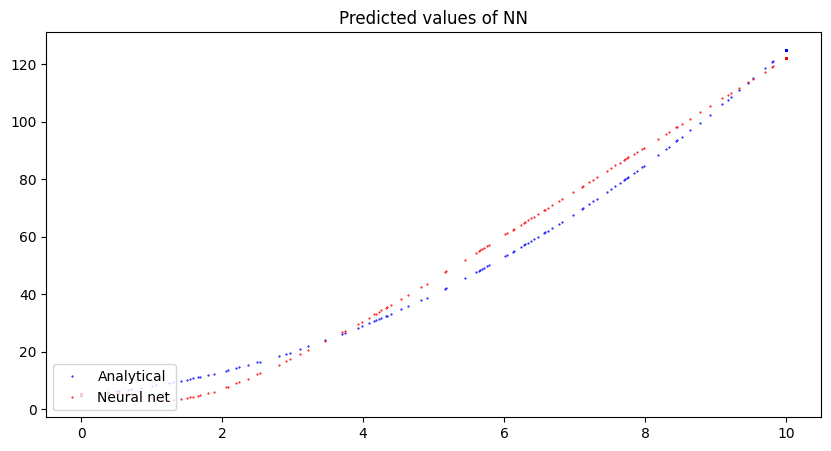

In [78]:
 # evaluate network at different points, show results
test_y_eval = net(test_x) #predictes y values of test set of the trained model
test_y_eval_np = test_y_eval.detach().numpy() #converts it to numpy array

# plot analytical solution vs predicted values of test set
plt.figure(figsize=(10, 5))
plt.plot(test[:,0], test[:,1], color = "blue", marker='o', linestyle='none', markersize=0.5)
plt.plot(test[:,0], test_y_eval_np, color = "red", marker='o', linestyle='none', markersize=0.5)
plt.title("Predicted values of NN")
plt.legend(["Analytical", "Neural net"], loc="lower left")